In [1]:
import os
import torch
import pandas as pd
import scanpy as sc
from sklearn import metrics
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt
from ProPaST import ProPaST
from scipy import sparse
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['R_HOME'] ='/home/maqinlin/miniconda3/envs/lib/R'


In [2]:
n_clusters = 12
datasets = ['10X_DAPI','10X_FFPE']#,'10X_DAPI',10X_FFPE ,'10X_Normal'
file_fold = "/home/maqinlin/mz_project/Data/Mouse_Brain_section/"
np.random.seed(42)


In [3]:
adatas = []
for dataset in datasets:
    adata = sc.read_visium(file_fold + dataset, count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique()
    adata.obs['batch'] = dataset

    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)  # 降低高变基因数量
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata = adata[:, adata.var['highly_variable']]
    adatas.append(adata)

/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata = adatas[0].concatenate(adatas[1:], batch_key='batch')

/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


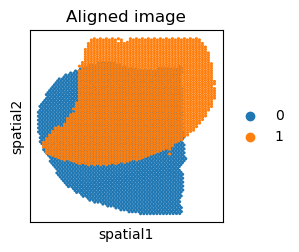

In [5]:
plt.rcParams["figure.figsize"] = (2.5, 2.5)
ax = sc.pl.embedding(adata, basis='spatial',
                color='batch',
                show=False,size = 20)
ax.set_title('Aligned image')
fig = ax.get_figure()   


In [6]:
model = ProPaST.ProPaST(adata, n_clusters,device=device)
adata = model.train()

dim_out = 64
Building matrix ...
Begin to train ST data for embedding...


100%|██████████| 600/600 [01:41<00:00,  5.91it/s]


Optimization finished for ST data!


In [ ]:
from ProPaST.utils import clustering
clustering(adata, n_clusters, method="mclust")

In [8]:
import scanpy as sc
import scib

scib.me.ilisi_graph(adata, batch_key="batch", type_="embed", use_rep="emb",scale = False)

/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.7394408421841991

In [29]:
adata.obs_names = adata.obs_names.str.rsplit('-', n=1).str[0]
batch1_barcodes = adata.obs_names[adata.obs['batch'] == '0']
batch2_barcodes = adata.obs_names[adata.obs['batch'] == '1']
common_barcodes = np.intersect1d(batch1_barcodes, batch2_barcodes)
adata.obs['overlap'] = adata.obs_names.isin(common_barcodes)

In [37]:
adata.obs["batch"] = adata.obs["batch"].astype(str)

adata.obs["batch"].replace(
    {"0": "10X_DAPI", "1": "10X_FFPE"},
    inplace=True
)

/home/maqinlin/miniconda3/envs/PPGCL/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


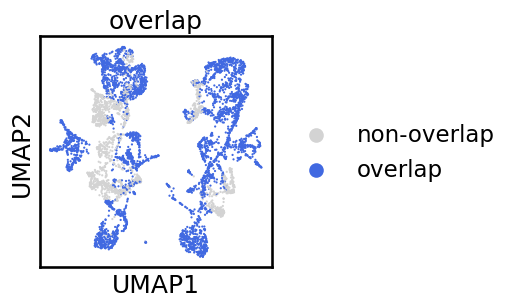

In [39]:
adata.obsm['spatial'][:, 1] = -1*adata.obsm['spatial'][:, 1]
plt.rcParams["figure.figsize"] = (3,3)
### Plotting UMAP before batch effect correction
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)

sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)


# 将 0/1 转为分类
adata.obs["overlap"] = adata.obs["overlap"].map({False: "non-overlap", True: "overlap"}).astype("category")

# 指定分类颜色
adata.uns["overlap_colors"] = ["lightgray", "royalblue"]

# 画图
ax = sc.pl.umap(
    adata,
    color="overlap",
    show=False,
    size=10,
    colorbar_loc=None
)

# 获取对应的 Figure 对象
fig = ax.get_figure()

